# Projekat 2023/24 MU

## Autoenkoder+SINDy za identifikaciju niskodimenzionalnog modela

### Nikita Jokić 2023/3279

In [1]:
import sys
sys.path.append("../../src")

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import os
from spring_example import get_spring_data, generate_spring_data
from scipy.integrate import odeint, solve_ivp
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate

## Postavka problema

Potrebno je identifikovati model linearnog harmonijskog oscilatora: 

$$m\frac{d^2}{dt^2}x + b\frac{d}{dt}x +kx = 0$$

Na raspolaganju su opservacije iz 60-dimenzionog prostora dobijene nelinearnom kombinacijom stanja opruge:

$$y = h(\frac{d}{dt}x, x)$$

Prilikom generisanja opservacija korišćeni su Legendre polinomi i kubovi promenljivih stanja.

Obučavajući skup je formiran simulacijom opruge za različite početne uslove.

Sledi prikaz trajektorja iz obučavajućeg skupa.


In [2]:
num_examples = 4
train_data = get_spring_data(num_examples)

### Simulirana stanja

(1156, 2)


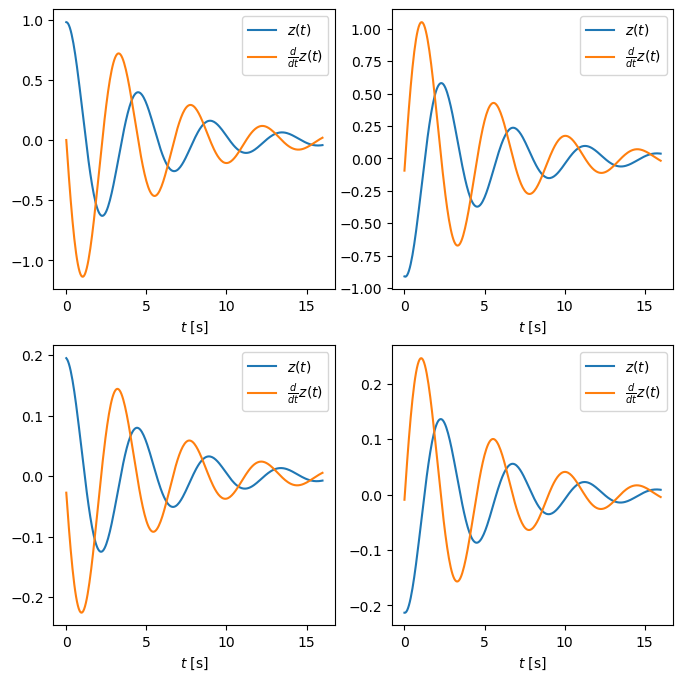

In [3]:

t = train_data['t']
z = train_data['z']
print(z.shape)
dz = train_data['dz']
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for i in range(num_examples):
    axes[i].plot(t, z[len(t)*i : len(t)*(i+1), 0], label='$z(t)$')
    axes[i].plot(t, z[len(t)*i : len(t)*(i+1), 1], label=r'$\frac{d}{dt}z(t)$') # first derivative dx
    axes[i].legend()
    axes[i].set_xlabel('$t$ [s]')
plt.savefig('original_trajectories.png', dpi=600)
plt.show()

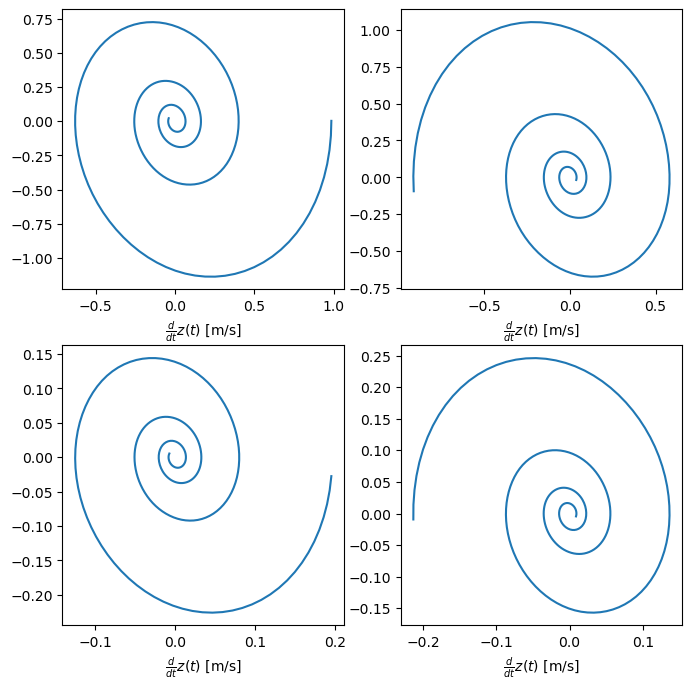

In [4]:
t = train_data['t']
z = train_data['z']
dz = train_data['dz']
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for i in range(num_examples):
    axes[i].plot(z[len(t)*i : len(t)*(i+1), 0], z[len(t)*i : len(t)*(i+1), 1])
    axes[i].set_xlabel('$z(t)$ [m]')
    axes[i].set_xlabel(r'$\frac{d}{dt}z(t)$ [m/s]')
    
plt.savefig('original_trajectories_ss.png', dpi=600)    
plt.show()

### Opservirana stanja

(1156, 60)
(1156, 60)


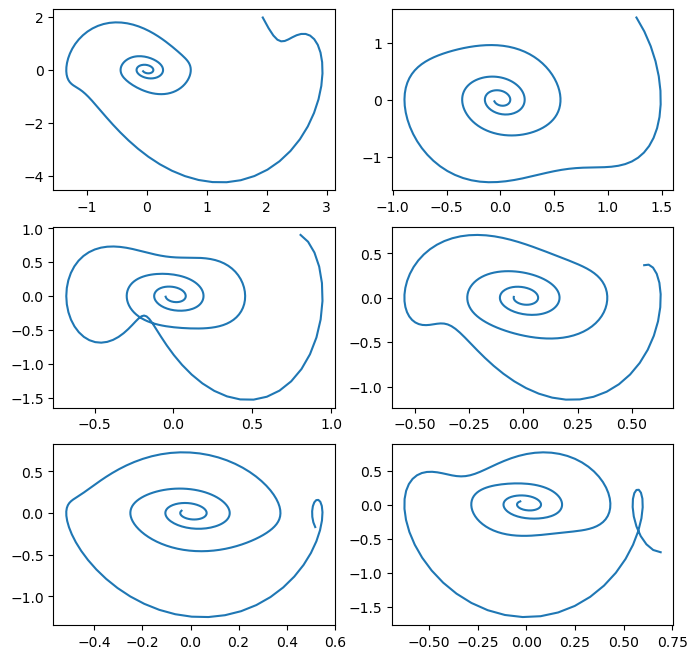

In [5]:
x = train_data['x'] 
dx = train_data['dx'] 
n = (x.shape[1])
print(x.shape)
print(dx.shape)

figures = 6
fig, axes = plt.subplots(figures//2, 2, figsize=(8, 8))
axes = axes.ravel()

for i in range(figures):
    axes[i].plot(x[0:len(t), i*8], dx[0:len(t), i*8], label='$x(t)$')
    #axes[i].plot(t, , label=r'$\frac{d}{dt}x(t)$') # first derivative dx
    #axes[i].legend()
    

    
plt.savefig('transformed_trajectories_ss.png', dpi=600)
plt.show()

## Autoenkoder+SINDy:

U ovom problemu zadatak autoenkodera je da nauči iz podataka odgovarajuće preslikavanje koje će nas prevesti u prostor stanja u kome je moguće formulisati pojednostavljen model.

SINDy postupak se sprovodi baš u latentnom prosotru. SINDy podrazumeva sledeću linearnu regresiju uz L1 regularizaciju:
$$ \dot{X} = \Theta{(X)}\Xi $$

$\Theta{(X)}$ predstavlja biblioteku linearnih i nelinearnih članova. Problem sa ovim prostupom je to što složenost ove biblioteke raste faktorijenlo sa porastom broja stanja i funkcija, pa je praktično nemoguće odrediti model na ovaj način u prostoru opservacija.

Sprovođenjem ovog postupka u latentnom podprostoru činimo problem rešivim. 

Razlog za uvođenje L1 regularizacije je da pospešimo fizičku interpretabilnost modela. Međutim, LASSO rezultuje nestabilnim učenjem. Kao rešenje se uvodi sekvencijalna LS regresija gde povremeno potiskujemo sve vrednosti koeficijenata manjih od nekog $\epsilon$.

Prilikom obučavanja autoenkodera korisitmo sledeći gubitak: ($\phi(x)$ predstavlja enkoder, a $\psi(z)$ dekoder)

$$ L = ||x-\psi(\phi(x))||^2_2 + l_1||\dot{x} - (\nabla_z\psi(\phi(x)))\Theta(\phi(x))\Xi||^2_2 + l_2||(\nabla_x\phi(x))\dot{x} - \Theta(\phi(x))\Xi||^2_2  + l_3||\Xi||_1
 $$
 
 
Tumačenje članova: 

   (1) $||x-\psi(\phi(x))||^2_2$ greška rekonstrukcije
    
   (2) $||\dot{x} - (\nabla_z\psi(\phi(x)))\Theta(\phi(x))\Xi||^2_2$ greška SINDy modela u originalnom prosotru
    
   (3) $||(\nabla_x\phi(x))\dot{x} - \Theta(\phi(x))\Xi||^2_2$ greška SINDy modela u latentnom prosotru
    
   (4) $||\Xi||_1$ regularizacija SINDy modela

In [6]:
import pandas as pd
# get the parameters obtained from the training of the sindy autoencoder NN
data_path = os.getcwd() + '/'
save_name = 'experiment_results_4_0.pkl'
params = pickle.load(open(data_path + save_name, 'rb'))
params['save_name'] = data_path + save_name
#print(params['num_epochs'])

autoencoder_network = full_network(params)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.compat.v1.train.Saver(var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

### Generisanje test primera

Prvo generišemo test primere sa istom opsegom početnih uslova kao  kod obučavajućeg skupa.

In [7]:
num_examples = 20
test_data = get_spring_data(num_examples, spread=1)


In [8]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from C:\Users\milos\OneDrive\IX_semestar_master\masinsko ucenje\SindyAutoencoders\examples\spring/experiment_results_4_0.pkl


In [9]:
params_f = {'b':0.2, 'k':1., 'm':0.5}

true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)

true_coefficients[2,0] = 1
true_coefficients[1,1] = -params_f['k']/params_f['m'] 
true_coefficients[2,1] = -params_f['b']/params_f['m'] 

print(true_coefficients)
print(params['coefficient_mask']*test_set_results['sindy_coefficients'])


n_ics = 10
z_sim = np.zeros((n_ics, t.size, 2))
spring_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate(test_set_results['z'][i*t.size], t,
                                params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                params['poly_order'], params['include_sine'])
    spring_sim[i] = sindy_simulate(test_set_results['z'][i*t.size], t,
                                true_coefficients,
                                params['poly_order'], params['include_sine'])

[[ 0.   0. ]
 [ 0.  -2. ]
 [ 1.  -0.4]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]
[[ 0.         -0.        ]
 [-0.30602172 -1.378829  ]
 [ 1.4179949  -0.20785056]
 [-0.         -0.        ]
 [ 0.         -0.        ]
 [ 0.         -0.        ]]


## Estimirani model: 

Primenom SINDy u latentnom prostoru došli smo do sledećeg modela:

$$\dot{z}_1 = -0.306 z_1 + 1.418 z_2$$
$$\dot{z}_2 = -1.378 z_1 -0.208 z_2$$

Pravi model glasi: 

$$\dot{z}_1 = z_2$$
$$\dot{z}_2 = -2 z_1 -0.4 z_2$$

Ovaj rezultat može dodatno da se poboljša ako se produži obučavanje, opravdanje za to je to što je validaciona greška imala tendenciju pada.

Sledi vizuelizacija trajektorija.

### Trajektorije unutar distribucije obučavajućeg skupa

Na osnovu izdvojenih trajektorija vidimo da simulirana trajektorija (simuliramo oprugu u latentnom prostoru na osnovu SINDy parametara) odgovara opserviranoj trajektoriji u latentnom prostoru. 

Dobro je poklapanje sa pravim podacima.

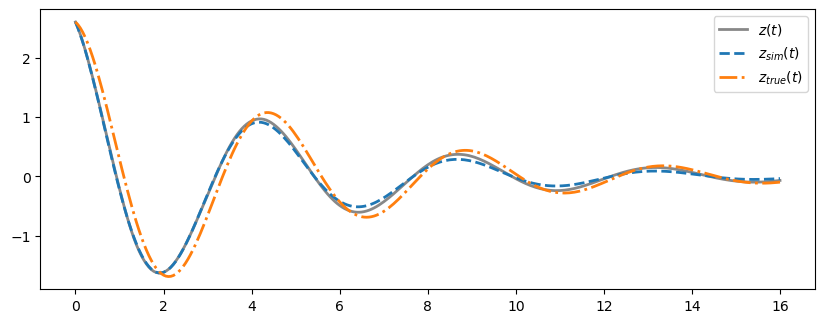

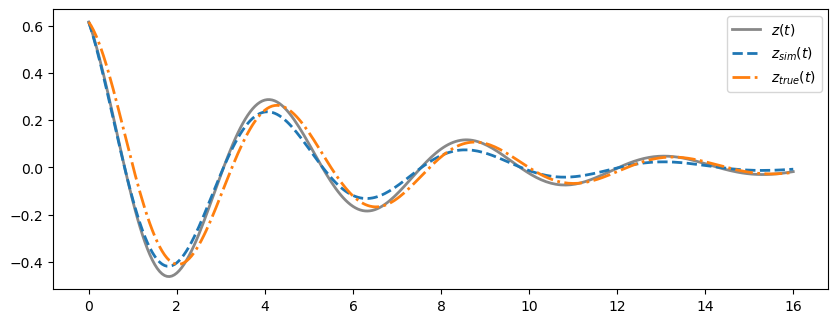

In [10]:

ic_idx = 0
t = train_data['t']
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(t, test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], color='#888888', linewidth=2, label='$z(t)$')
plt.plot(t, z_sim[ic_idx,:,0], '--', linewidth=2, label='$z_{sim}(t)$')
plt.plot(t, spring_sim[ic_idx,:,0], '-.', linewidth=2, label='$z_{true}(t)$')
plt.legend()
plt.savefig('prediction_in_dist_1.png', dpi=600)
plt.show()


ic_idx = 5
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(t, test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], color='#888888', linewidth=2, label='$z(t)$')
plt.plot(t, z_sim[ic_idx,:,0], '--', linewidth=2, label='$z_{sim}(t)$')
plt.plot(t, spring_sim[ic_idx,:,0], '-.', linewidth=2, label='$z_{true}(t)$')
plt.legend()
plt.savefig('original_trajectories.png', dpi=600)
plt.savefig('prediction_in_dist_2.png', dpi=600)
plt.show()

Greške su u skladu sa greškama tokom obučavanja.

In [11]:

test_data = get_spring_data(10)
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy relative error, z: %f' % sindy_dz_error)

INFO:tensorflow:Restoring parameters from C:\Users\milos\OneDrive\IX_semestar_master\masinsko ucenje\SindyAutoencoders\examples\spring/experiment_results_4_0.pkl
Decoder relative error: 0.000018
Decoder relative SINDy error: 0.001436
SINDy relative error, z: 0.001884


### Generisanje test primera van distribucije obučavajućeg skupa

Generišemo test primere sa 40 puta većim opsegom početnih vrednosti.

In [12]:
num_examples = 20
test_data = get_spring_data(num_examples, spread=20)


In [13]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from C:\Users\milos\OneDrive\IX_semestar_master\masinsko ucenje\SindyAutoencoders\examples\spring/experiment_results_4_0.pkl


In [14]:
params_f = {'b':0.2, 'k':1., 'm':0.5}

true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)

true_coefficients[2,0] = 1
true_coefficients[1,1] = -params_f['k']/params_f['m'] 
true_coefficients[2,1] = -params_f['b']/params_f['m'] 


n_ics = 10
z_sim = np.zeros((n_ics, t.size, 2))
spring_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate(test_set_results['z'][i*t.size], t,
                                params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                params['poly_order'], params['include_sine'])
    spring_sim[i] = sindy_simulate(test_set_results['z'][i*t.size], t,
                                true_coefficients,
                                params['poly_order'], params['include_sine'])

### Trajektorije van distribucije obučavajućeg skupa

Na osnovu izdvojenih trajektorija vidimo da simulirana trajektorija (simuliramo oprugu u latentnom prostoru na osnovu SINDy parametara) više ne odgovara opserviranoj trajektoriji u latentnom prostoru. Razlog za ovo je to što autoenkoder nije u stanju da generalizuje, pa u skladu sa tim naučeno nelinearno preslikavanje gubi na kvalitetu van ditribucije obučavajućeg skupa.

Sa druge strane simulacija SINDy parametrizacije iz latetnog prostora i dalje daje dobre rezultate. Ovo predstavlja veliku prednost SINDy pristpua, za razliku od pritupa na bazi neuralnih mreža može da generalizuje i van ditribucije obučavajućeg skupa.

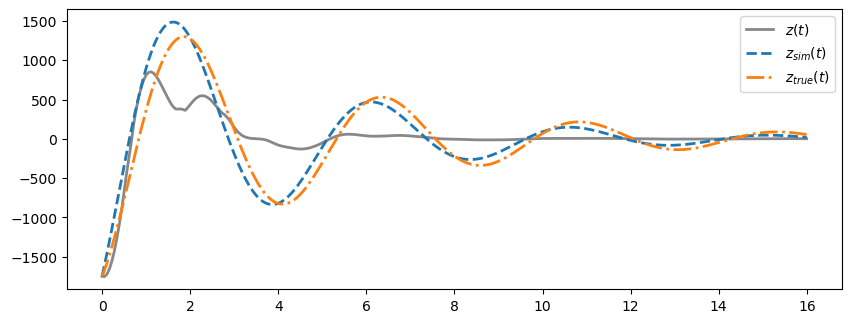

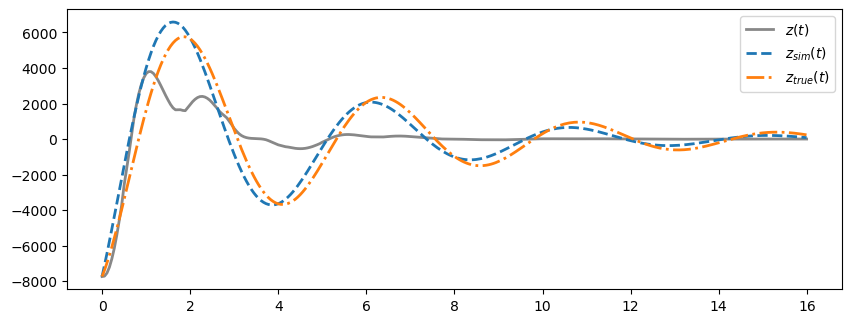

In [15]:
# trajectory of the latent variable z(t) and simulated trajectory
ic_idx = 1 

t = train_data['t']
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(t, test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], color='#888888', linewidth=2, label='$z(t)$')
plt.plot(t, z_sim[ic_idx,:,0], '--', linewidth=2, label='$z_{sim}(t)$')
plt.plot(t, spring_sim[ic_idx,:,0], '-.', linewidth=2, label='$z_{true}(t)$')
plt.legend()
plt.savefig('prediction_out_dist_1.png', dpi=600)
plt.show()


ic_idx = 8
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(t, test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], color='#888888', linewidth=2, label='$z(t)$')
plt.plot(t, z_sim[ic_idx,:,0], '--', linewidth=2, label='$z_{sim}(t)$')
plt.plot(t, spring_sim[ic_idx,:,0], '-.', linewidth=2, label='$z_{true}(t)$')
plt.savefig('prediction_out_dist_2.png', dpi=600)
plt.legend()
plt.show()

Kao što je i očekivano, greška je značajno porasla.

In [16]:

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy relative error, z: %f' % sindy_dz_error)

INFO:tensorflow:Restoring parameters from C:\Users\milos\OneDrive\IX_semestar_master\masinsko ucenje\SindyAutoencoders\examples\spring/experiment_results_4_0.pkl
Decoder relative error: 0.462180
Decoder relative SINDy error: 0.812680
SINDy relative error, z: 0.822621
